In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from MC_methods import first_visit_mc_policy_evaluation

## Blackjack

The object of the popular casino card game of *blackjack* is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goe bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21.

Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, -1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero, and we do not discount ($\gamma$ = 1); therefore these terminal rewards are also the returns. The player’s actions are to hit or to stick. The states depend on the player’s cards and the dealer’s showing card. We assume that cards are dealt from an infinite deck (i.e., with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: his current sum (12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable ace.

Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.

In [2]:
# Create states and policy
states = []
for sum_player in range(12, 22):
    for sum_dealer in range(1, 11):
        for usable_ace in [True, False]:
            state = (sum_player, sum_dealer, usable_ace)
            states.append(state)

ACTIONS = ['hits', 'sticks']
policy = {}
for s in states:
    if s[0] >= 20:
        policy[s] = ACTIONS[1]
    else:
        policy[s] = ACTIONS[0]

In [3]:
# Create the function to generate an episoed: a list of (state, action, reward)
def generate_episode_blackjack(policy: dict):
    """
    Returns:
        episode: a list of (state, action, reward) tuples.
    """

    def draw_card():
        card = np.random.randint(1, 14)
        return min(card, 10)
    
    def draw_hand():
        return [draw_card(), draw_card()]
    
    def usable_ace(hand: list):
        return 1 in hand and sum(hand) + 11 <= 21
    
    def sum_hand(hand: list):
        total = sum(hand)
        if 1 in hand and total + 11 <= 21:
            return total + 11
        return total
    
    def is_bust(hand):
        return sum_hand(hand) > 21
    
    def dealer_policy(dealer_hand):
        while sum_hand(dealer_hand) < 17:
            dealer_hand.append(draw_card())
        return dealer_hand
    
    # Initialize the game
    player_hand = draw_hand()
    dealer_hand = draw_hand()
    dealer_showing = dealer_hand[0]

    episode = []

    while sum_hand(player_hand) < 12:
        player_hand.append(draw_card())
    
    while True:
        player_sum = sum_hand(player_hand)
        usable = usable_ace(player_hand)
        state = (player_sum, dealer_showing, usable)

        action = policy[state] if state in policy else ('sticks' if player_sum >= 20 else 'hits')

        episode.append((state, action, 0))

        if action == 'hits':
            player_hand.append(draw_card())
            if is_bust(player_hand):
                episode.append(((sum_hand(player_hand), dealer_showing, usable_ace(player_hand)), None, -1))
                return episode
        
        else:
            break
    
    dealer_hand = dealer_policy(dealer_hand)

    if is_bust(dealer_hand):
        reward = 1
    else:
        player_total = sum_hand(player_hand)
        dealer_total = sum_hand(dealer_hand)
        if player_total > dealer_total:
            reward = 1
        elif player_total < dealer_total:
            reward = -1
        else:
            reward = 0
    
    episode.append(((sum_hand(player_hand), dealer_showing, usable_ace(player_hand)), None, reward))
    return episode

In [4]:
# Run the policy evaluation on the Blackjack example
first_visit_mc_policy_evaluation(states=states,
                                 policy=policy,
                                 generate_episode_fn=generate_episode_blackjack,
                                 gamma=1,
                                 num_episodes=1000)

KeyError: (29, 10, False)

## Blackjack ES

We now want to seek the optimal policy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from MC_methods import mc_control_es

In [ ]:
# Creamos la lista de states
states = []
for s in range(12, 22):
    for d in range(1, 11):
        for usable in [True, False]:
            states.append((s, d, usable))
len(states)

200

In [ ]:
states_without_usable_ace = []
for s in range(12, 22):
    for d in range(1, 11):
        states_without_usable_ace.append((s, d))
len(states_without_usable_ace)

100

In [ ]:
# Creamos el diccionario de acciones
ACTIONS = ['hits', 'sticks']
actions = {}
for s in states:
    actions[s] = ACTIONS
len(actions)

200

In [ ]:
# Creamos el diccionario de acciones
actions_without_usable_ace = {}
for s in states_without_usable_ace:
    actions_without_usable_ace[s] = ACTIONS
len(actions_without_usable_ace)

100

In [ ]:
# Creamos la función para generar episodios
def generate_episode_es_blackjack(initial_state: tuple, 
                                  initial_action: str, 
                                  policy: dict):
    """
    inital_state: (player_sum, showing_dealer_card, usable_ace)
    initial_action: string --> 'hits' or 'sticks'
    policy: dict

    Devuelve una lista de tuplas [(s0, a0, r1), (s1, a1, r2), ..., (sT-1, aT-1, rT)]
    """

    # Mano del dealer
    dealer_usable_ace = False
    showing_dealer_card = initial_state[1]
    if showing_dealer_card == 1:
        showing_dealer_card == 11
        dealer_usable_ace = True
    card_dealer = np.random.randint(1, 14)
    if card_dealer > 10:
        card_dealer = 10
    if (card_dealer == 1) and (showing_dealer_card + 11 <= 21):
        card_dealer = 11
        dealer_usable_ace = True
    sum_dealer = showing_dealer_card + card_dealer
    
    # Función auxiliar para crear la policy del dealer
    def policy_dealer(sum_dealer: int, dealer_usable_ace: bool):
        if sum_dealer >= 17:
            return sum_dealer
        else:
            card = np.random.randint(1, 14)
            if card > 10:
                card = 10

            if (card == 1) and ((sum_dealer + 11) <= 21):
                sum_dealer = sum_dealer + 11
                dealer_usable_ace = True
                return policy_dealer(sum_dealer, dealer_usable_ace)
            elif (sum_dealer + card > 21) and (dealer_usable_ace == True):
                sum_dealer = sum_dealer + card - 10
                dealer_usable_ace = False
                return policy_dealer(sum_dealer, dealer_usable_ace)
            elif (sum_dealer + card > 21) and (dealer_usable_ace == False):
                return sum_dealer + card
            return policy_dealer(sum_dealer + card, dealer_usable_ace)

    # Inicializamos la lista de los steps del episodio
    episodio = []
    reward = 0
    # Si la acción es hits el dealer nos dará una carta
    if initial_action == 'hits':
        card = np.random.randint(1, 14)
        if card > 10:
            card = 10
        next_state = (initial_state[0] + card, initial_state[1], initial_state[2])
        # Calculamos la reward
        if (next_state[0] > 21) and (next_state[2] == False):
            reward = -1
            episodio.append((initial_state, initial_action, reward))
            return episodio
        elif (next_state[0] > 21) and (next_state[2] == True):
            next_state = (next_state[0] - 10, next_state[1], False)
            episodio.append((initial_state, initial_action, 0))
        episodio.append((initial_state, initial_action, 0))
    else:
        total_sum_dealer = policy_dealer(sum_dealer, dealer_usable_ace)
        if total_sum_dealer > 21:
            reward = 1
            episodio.append((initial_state, initial_action, reward))
            return episodio
        else:
            if total_sum_dealer > initial_state[0]:
                reward = -1
                episodio.append((initial_state, initial_action, reward))
                return episodio
            elif total_sum_dealer == initial_state[0]:
                episodio.append((initial_state, initial_action, reward))
                return episodio
            else:
                reward = 1
                episodio.append((initial_state, initial_action, reward))
                return episodio

    # Hay que seguir la policy
    while True:
        next_action = policy[next_state]
        # Si la próxima acción es sticks se termina el juego
        if next_action == 'sticks':
            total_sum_dealer = policy_dealer(sum_dealer, dealer_usable_ace)
            if total_sum_dealer > 21:
                reward = 1
                episodio.append((next_state, next_action, reward))
                return episodio
            else:
                if total_sum_dealer > next_state[0]:
                    reward = -1
                    episodio.append((next_state, next_action, reward))
                    return episodio
                elif total_sum_dealer == next_state[0]:
                    episodio.append((next_state, next_action, 0))
                    return episodio
                else:
                    reward = 1
                    episodio.append((next_state, next_action, reward))
                    return episodio
        else:
            next_card = np.random.randint(1, 14)
            if next_card > 10:
                next_card = 10
            # Calculamos la reward
            next_player_sum = next_state[0] + next_card
            if (next_player_sum > 21) and (next_state[2] == False):
                reward = -1
                episodio.append((next_state, next_action, -1))
                return episodio
            elif (next_player_sum > 21) and (next_state[2] == True):
                episodio.append((next_state, next_action, 0))
                next_state = (next_player_sum - 10, next_state[1], False)
            else:
                episodio.append((next_state, next_action, 0))
                next_state = (next_player_sum, next_state[1], next_state[2])

In [ ]:
Q, policy = mc_control_es(states=states,
              actions=actions,
              generate_episode_es_fn=generate_episode_es_blackjack,
              num_episodes=100000)

In [ ]:
policy

{(12, 1, True): 'hits',
 (12, 1, False): 'hits',
 (12, 2, True): 'hits',
 (12, 2, False): 'hits',
 (12, 3, True): 'hits',
 (12, 3, False): 'sticks',
 (12, 4, True): 'hits',
 (12, 4, False): 'hits',
 (12, 5, True): 'hits',
 (12, 5, False): 'sticks',
 (12, 6, True): 'hits',
 (12, 6, False): 'hits',
 (12, 7, True): 'hits',
 (12, 7, False): 'hits',
 (12, 8, True): 'hits',
 (12, 8, False): 'hits',
 (12, 9, True): 'hits',
 (12, 9, False): 'hits',
 (12, 10, True): 'hits',
 (12, 10, False): 'hits',
 (13, 1, True): 'hits',
 (13, 1, False): 'hits',
 (13, 2, True): 'hits',
 (13, 2, False): 'hits',
 (13, 3, True): 'hits',
 (13, 3, False): 'sticks',
 (13, 4, True): 'hits',
 (13, 4, False): 'hits',
 (13, 5, True): 'hits',
 (13, 5, False): 'sticks',
 (13, 6, True): 'hits',
 (13, 6, False): 'sticks',
 (13, 7, True): 'hits',
 (13, 7, False): 'hits',
 (13, 8, True): 'hits',
 (13, 8, False): 'hits',
 (13, 9, True): 'hits',
 (13, 9, False): 'hits',
 (13, 10, True): 'hits',
 (13, 10, False): 'hits',
 (14, 

## Racetrack

Consider driving a race car around a turn. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions. The velocity is also discrete, a number of grid cells moved horizonatlly and vertically per time step. The actions are increments to the velocity components. Each may be changed  by +1, -1, or 0 in each step, for a total of nine (3 x 3) actions. Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. 

The rewards are -1 for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues.

Before updating the car's location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it interescts anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments.

In [26]:
import numpy as np
from MC_methods import mc_control_off_policy_every_visit

Primero hay que crear el mapa o `track`.

In [27]:
track = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

Los `states` serán la posición en la que nos encontramos, combinada con la velocidad que llevamos.

In [38]:
# Create states
states = []
n, m = track.shape
for pos_i in range(n):
    for pos_j in range(m):
        for vx in range(5):
            for vy in range(5):
                if (track[pos_i, pos_j] == 0) or (track[pos_i, pos_j] == 3):
                    continue
                states.append((pos_i, pos_j, vx, vy))

Las `actions` serán sumar o restar 1, o quedarse igual, tanto la componente x como y.

In [39]:
# Create actions
actions = {}
for state in states:
    actions[state] = [(increment_x, increment_y) for increment_x in [1, 0, -1] for increment_y in [1, 0, -1]]

La función para generar cada episodio tiene que tener en cuenta:

1. El movimiento del coche, una vez dado el `state` y la `action`. Con probabilidad de 0.1 de no moverse.
2. El `reward` en cada `action` --> Cada vez que se mueve es $-1$.
3. Verificar si el coche golpea la `track boundary`, la `finish line` o nada.

In [ ]:
def move_old(state, action):
    if np.random.random() > 0.1:
        velocity = [state[2] + action[0], state[3] + action[1]]
        position = [state[0] - velocity[1], state[1] + velocity[0]]
    else:
        velocity = [0, 0]
        position = [state[0], state[1]]

    if velocity[0] >= 0 and velocity[1] >= 0 and velocity[0] < 5 and velocity[1] < 5:
        state = (position[0], position[1], velocity[0], velocity[1])
        return state
    elif velocity[0] < 0 and velocity[1] < 0:
        state = (state[0], state[1], 0, 0)
        return state
    elif velocity[0] < 0 and velocity[1] < 5:
        state = (state[0] - velocity[1], state[1], 0, velocity[1])
        return state
    elif velocity[1] < 0 and velocity[0] < 5:
        state = (state[0], state[1] + velocity[0], velocity[0], 0)
        return state
    elif velocity[0] >= 5 and velocity[1] >= 5:
        velocity[0], velocity[1] = 4, 4
        state = (state[0] - velocity[1], state[1] + velocity[0], velocity[0], velocity[1])
        return state
    elif velocity[0] >= 5 and velocity[1] >= 0:
        velocity[0] = 4
        state = (state[0] - velocity[1], state[1] + velocity[0], velocity[0], velocity[1])
        return state
    elif velocity[1] >= 5 and velocity[0] >= 0:
        velocity[1] = 4
        state = (state[0] - velocity[1], state[1] + velocity[0], velocity[0], velocity[1])
        return state
    elif velocity[0] < 0 and velocity[1] >= 5:
        velocity[0] = 0
        velocity[1] = 4
        state = (state[0] - velocity[1], state[1], velocity[0], velocity[1])
        return state
    elif velocity[1] < 0 and velocity[0] >= 5:
        velocity[0] = 4
        velocity[1] = 0
        state = (state[0] - velocity[1], state[1]+ velocity[0], velocity[0], velocity[1])
        return state

In [90]:
def move(state, action):
    pos = np.array([state[0], state[1]])
    vel = np.array([state[2], state[3]])
    acc = np.array([action[0], action[1]])

    # 10% de probabilidad de fallo -> coche se para
    if np.random.random() <= 0.1:
        return (pos[0], pos[1], 0, 0)

    # Actualización tentativa de velocidad
    new_vel = vel + acc

    # Comprobación de límites: si alguna velocidad está fuera del rango válido
    if np.any(new_vel < 0) or np.any(new_vel >= 5):
        return (pos[0], pos[1], 0, 0)

    # Movimiento de posición (recordamos: eje Y invertido vertical)
    new_pos = pos + np.array([ -new_vel[1], new_vel[0] ])  # (fila, columna)

    return (new_pos[0], new_pos[1], new_vel[0], new_vel[1])


In [45]:
def verify_position(state: tuple):
    init_line = np.where(track == 2)
    coords = list(zip(init_line[0], init_line[1]))
    try:
        if (track[state[0], state[1]] == 0) or (state[0] < 0) or (state[1] < 0):
            idx = np.random.randint(len(coords))
            random_init = coords[idx]
            state = (random_init[0], random_init[1], 0, 0)
            return state, True
        elif (track[state[0], state[1]] == 1 or track[state[0], state[1]] == 2):
            return state, False
        else:
            return True, None
    except IndexError:
        idx = np.random.randint(len(coords))
        random_init = coords[idx]
        state = (random_init[0], random_init[1], 0, 0)
        return state, True

In [48]:
def generate_episode_racetrack(behavior_policy: dict):
    episode = [] # episode = [(s0, a0, r0), (s1, a1, r1), ..., (sT, aT, rT)]
    # The car starts at a random coord of the starting line with velocity 0 at both
    init_line = np.where(track == 2)
    coords = list(zip(init_line[0], init_line[1]))
    idx = np.random.randint(len(coords))
    random_init = coords[idx]
    state = (random_init[0], random_init[1], 0, 0)
    # Take the action using the behavior policy
    actions = list(behavior_policy[state].keys())
    probs = list(behavior_policy[state].values())
    action_idx = np.random.choice(range(len(actions)), p=probs)
    action = actions[action_idx]
    # Update episode
    episode.append((state, action, -1))
    # Loop until finish
    state_action_resets = []
    count_episodes = 0
    while True:
        # Move the car
        state = move(state, action)
        # Verify the position
        if verify_position(state)[0] == True:
            print('---------------FINISIHED!-----------------')
            count_episodes += 1
            print(f'Número de episodios terminados: {count_episodes}')
            return episode
        else:
            if verify_position(state)[1] == True:
                state_action_resets.append((state, action))
            state = verify_position(state)[0]

        # Take the next action
        count = 0
        while True:
            count += 1
            probs = list(behavior_policy[state].values())
            action_idx = np.random.choice(range(len(actions)), p=probs)
            action = actions[action_idx]
            if (state, action) not in state_action_resets:
                break
            if count == 9:
                break
        # Update episode
        episode.append((state, action, -1))


In [92]:
Q, target_policy = mc_control_off_policy_every_visit(states=states,
                                  actions=actions,
                                  generate_episode_fn_behavior_policy=generate_episode_racetrack,
                                  gamma=1,
                                  num_episodes=5000)

---------------FINISIHED!-----------------
Número de episodios terminados: 1
Episodio número 1 terminado.
---------------FINISIHED!-----------------
Número de episodios terminados: 1
Episodio número 2 terminado.
---------------FINISIHED!-----------------
Número de episodios terminados: 1
Episodio número 3 terminado.
---------------FINISIHED!-----------------
Número de episodios terminados: 1
Episodio número 4 terminado.
---------------FINISIHED!-----------------
Número de episodios terminados: 1
Episodio número 5 terminado.
---------------FINISIHED!-----------------
Número de episodios terminados: 1
Episodio número 6 terminado.
---------------FINISIHED!-----------------
Número de episodios terminados: 1
Episodio número 7 terminado.
---------------FINISIHED!-----------------
Número de episodios terminados: 1
Episodio número 8 terminado.
---------------FINISIHED!-----------------
Número de episodios terminados: 1
Episodio número 9 terminado.
---------------FINISIHED!-----------------
Núm

In [93]:
initial_states = []
for pos_i in range(n):
    for pos_j in range(m):
        if track[pos_i, pos_j] == 2:
            initial_states.append((pos_i, pos_j, 0, 0))

initial_states

[(33, 4, 0, 0),
 (33, 5, 0, 0),
 (33, 6, 0, 0),
 (33, 7, 0, 0),
 (33, 8, 0, 0),
 (33, 9, 0, 0),
 (33, 10, 0, 0),
 (33, 11, 0, 0),
 (33, 12, 0, 0),
 (33, 13, 0, 0),
 (33, 14, 0, 0)]

In [113]:
state = (33, 6, 0, 0)
path = [(state[0], state[1])]
while True:
    try:
        act_x, act_y = target_policy[state]
        vel_x = act_x + state[2]
        vel_y = act_y + state[3]
        state = (state[0] - vel_y, state[1] + vel_x, vel_x, vel_y)
        path.append((state[0], state[1]))
    except KeyError:
        break

In [114]:
path

[(33, 6),
 (32, 7),
 (30, 9),
 (27, 10),
 (23, 10),
 (19, 10),
 (16, 10),
 (14, 10),
 (11, 11),
 (9, 13),
 (6, 16),
 (4, 20),
 (2, 24)]

### Graficamos la solución:

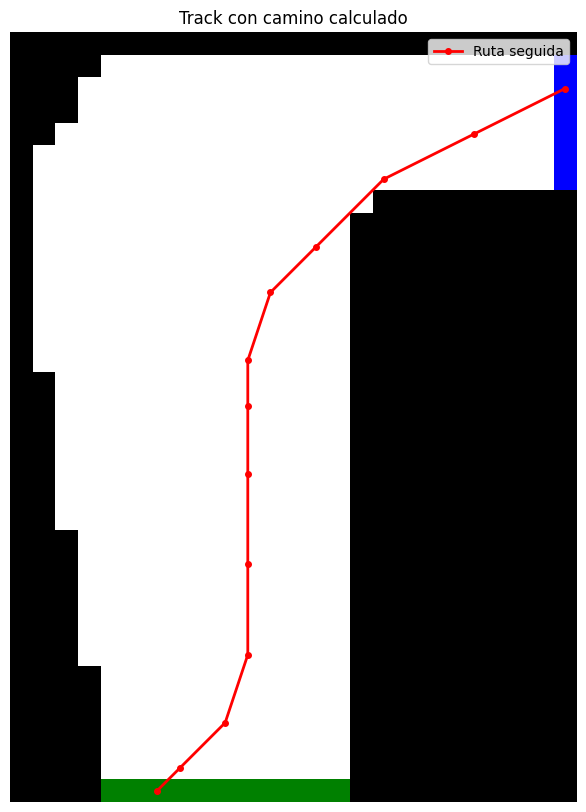

In [117]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Crear un mapa de colores para los valores de la pista
cmap = mcolors.ListedColormap(['black', 'white', 'green', 'blue'])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Mostrar el track
plt.figure(figsize=(10, 10))
plt.imshow(track, cmap=cmap, norm=norm)

# Extraer las coordenadas x (columnas) e y (filas) del camino
path_rows, path_cols = zip(*path)

# Superponer el camino con otro color (por ejemplo, rojo)
plt.plot(path_cols, path_rows, color='red', linewidth=2, marker='o', markersize=4, label="Ruta seguida")

# Invertir eje y para que se vea como en la matriz (fila 0 arriba)
plt.gca()

# Opcional: mostrar leyenda y título
plt.title("Track con camino calculado")
plt.legend()
plt.grid(False)
plt.axis('off')  # quitar ejes si prefieres visual limpio
plt.show()

In [134]:
state = (33, 7, 0, 0)
path = [(state[0], state[1])]
while True:
    try:
        act_x, act_y = target_policy[state]
        vel_x = act_x + state[2]
        vel_y = act_y + state[3]
        state = (state[0] - vel_y, state[1] + vel_x, vel_x, vel_y)
        path.append((state[0], state[1]))
    except KeyError:
        break

In [135]:
path

[(33, 7),
 (32, 8),
 (30, 9),
 (28, 11),
 (27, 13),
 (25, 14),
 (22, 14),
 (19, 14),
 (15, 14),
 (11, 14),
 (7, 15),
 (4, 17),
 (2, 20),
 (1, 24)]

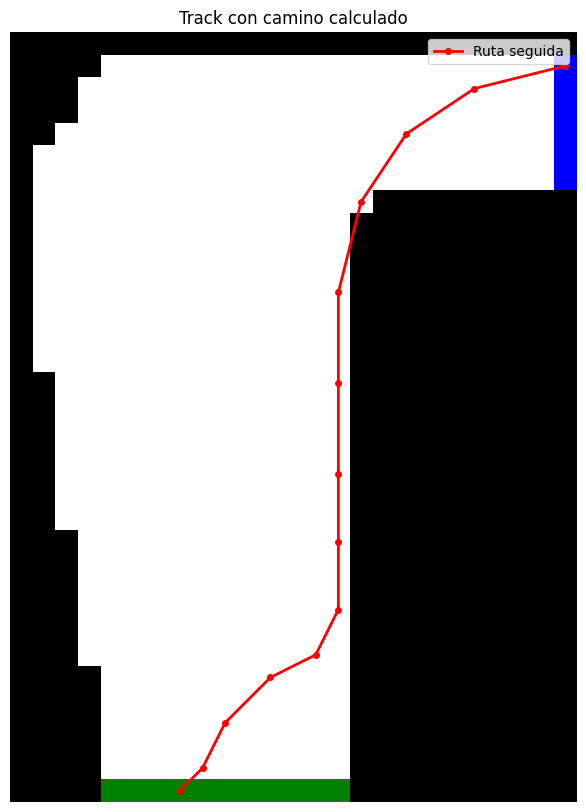

In [136]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Crear un mapa de colores para los valores de la pista
cmap = mcolors.ListedColormap(['black', 'white', 'green', 'blue'])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Mostrar el track
plt.figure(figsize=(10, 10))
plt.imshow(track, cmap=cmap, norm=norm)

# Extraer las coordenadas x (columnas) e y (filas) del camino
path_rows, path_cols = zip(*path)

# Superponer el camino con otro color (por ejemplo, rojo)
plt.plot(path_cols, path_rows, color='red', linewidth=2, marker='o', markersize=4, label="Ruta seguida")

# Invertir eje y para que se vea como en la matriz (fila 0 arriba)
plt.gca()

# Opcional: mostrar leyenda y título
plt.title("Track con camino calculado")
plt.legend()
plt.grid(False)
plt.axis('off')  # quitar ejes si prefieres visual limpio
plt.show()